In [1]:
import sys, os, subprocess
import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import pinyin
import re
import struct
import pickle


def get_image_page(pdf_file, out_file, page_num, resolution):
    page = str(page_num + 1)
    command = ["gs", "-q", "-dNOPAUSE", "-dBATCH", "-sDEVICE=png16m", "-r" + str(resolution), "-dPDFFitPage",
               "-sOutputFile=" + out_file, "-dFirstPage=" + page, "-dLastPage=" + page,
               pdf_file]
    f_null = open(os.devnull, 'w')
    subprocess.call(command, stdout=f_null, stderr=subprocess.STDOUT)
    
simkai = ImageFont.truetype("simkai.ttf", 64)
arial = ImageFont.truetype("/Library/Fonts/Arial Unicode.ttf", 24)

In [3]:
mandarin = {'chars': list(), 'imgs': []}
with open('Mandarin.dat','r') as f:
    for line in f:
        t = line.split('\t')
        mandarin['chars'].append({'unicode': int(t[0], 16), 'pinyin': t[1]})

In [5]:
def unichar(i):
    try:
        return unichr(i)
    except ValueError:
        return struct.pack('i', i).decode('utf-32')

In [6]:
mandarin['imgs'] = []

def get_char_img(cc):
    char = Image.new('RGB', (64, 64), 'white')
    draw = ImageDraw.Draw(char)
    draw.text((0, 0), cc ,(0,0,0),font=simkai)
    char = np.array(char)
    del draw
    return char

for i in range(0, len(mandarin['chars'])):
    mandarin['chars'][i]['char'] = unichar(mandarin['chars'][i]['unicode'])
    cc = mandarin['chars'][i]['char']
    mandarin['imgs'].append(get_char_img(cc).flatten())
    
mandarin['imgs'] = np.array(mandarin['imgs'])

(3300, 2550, 3)


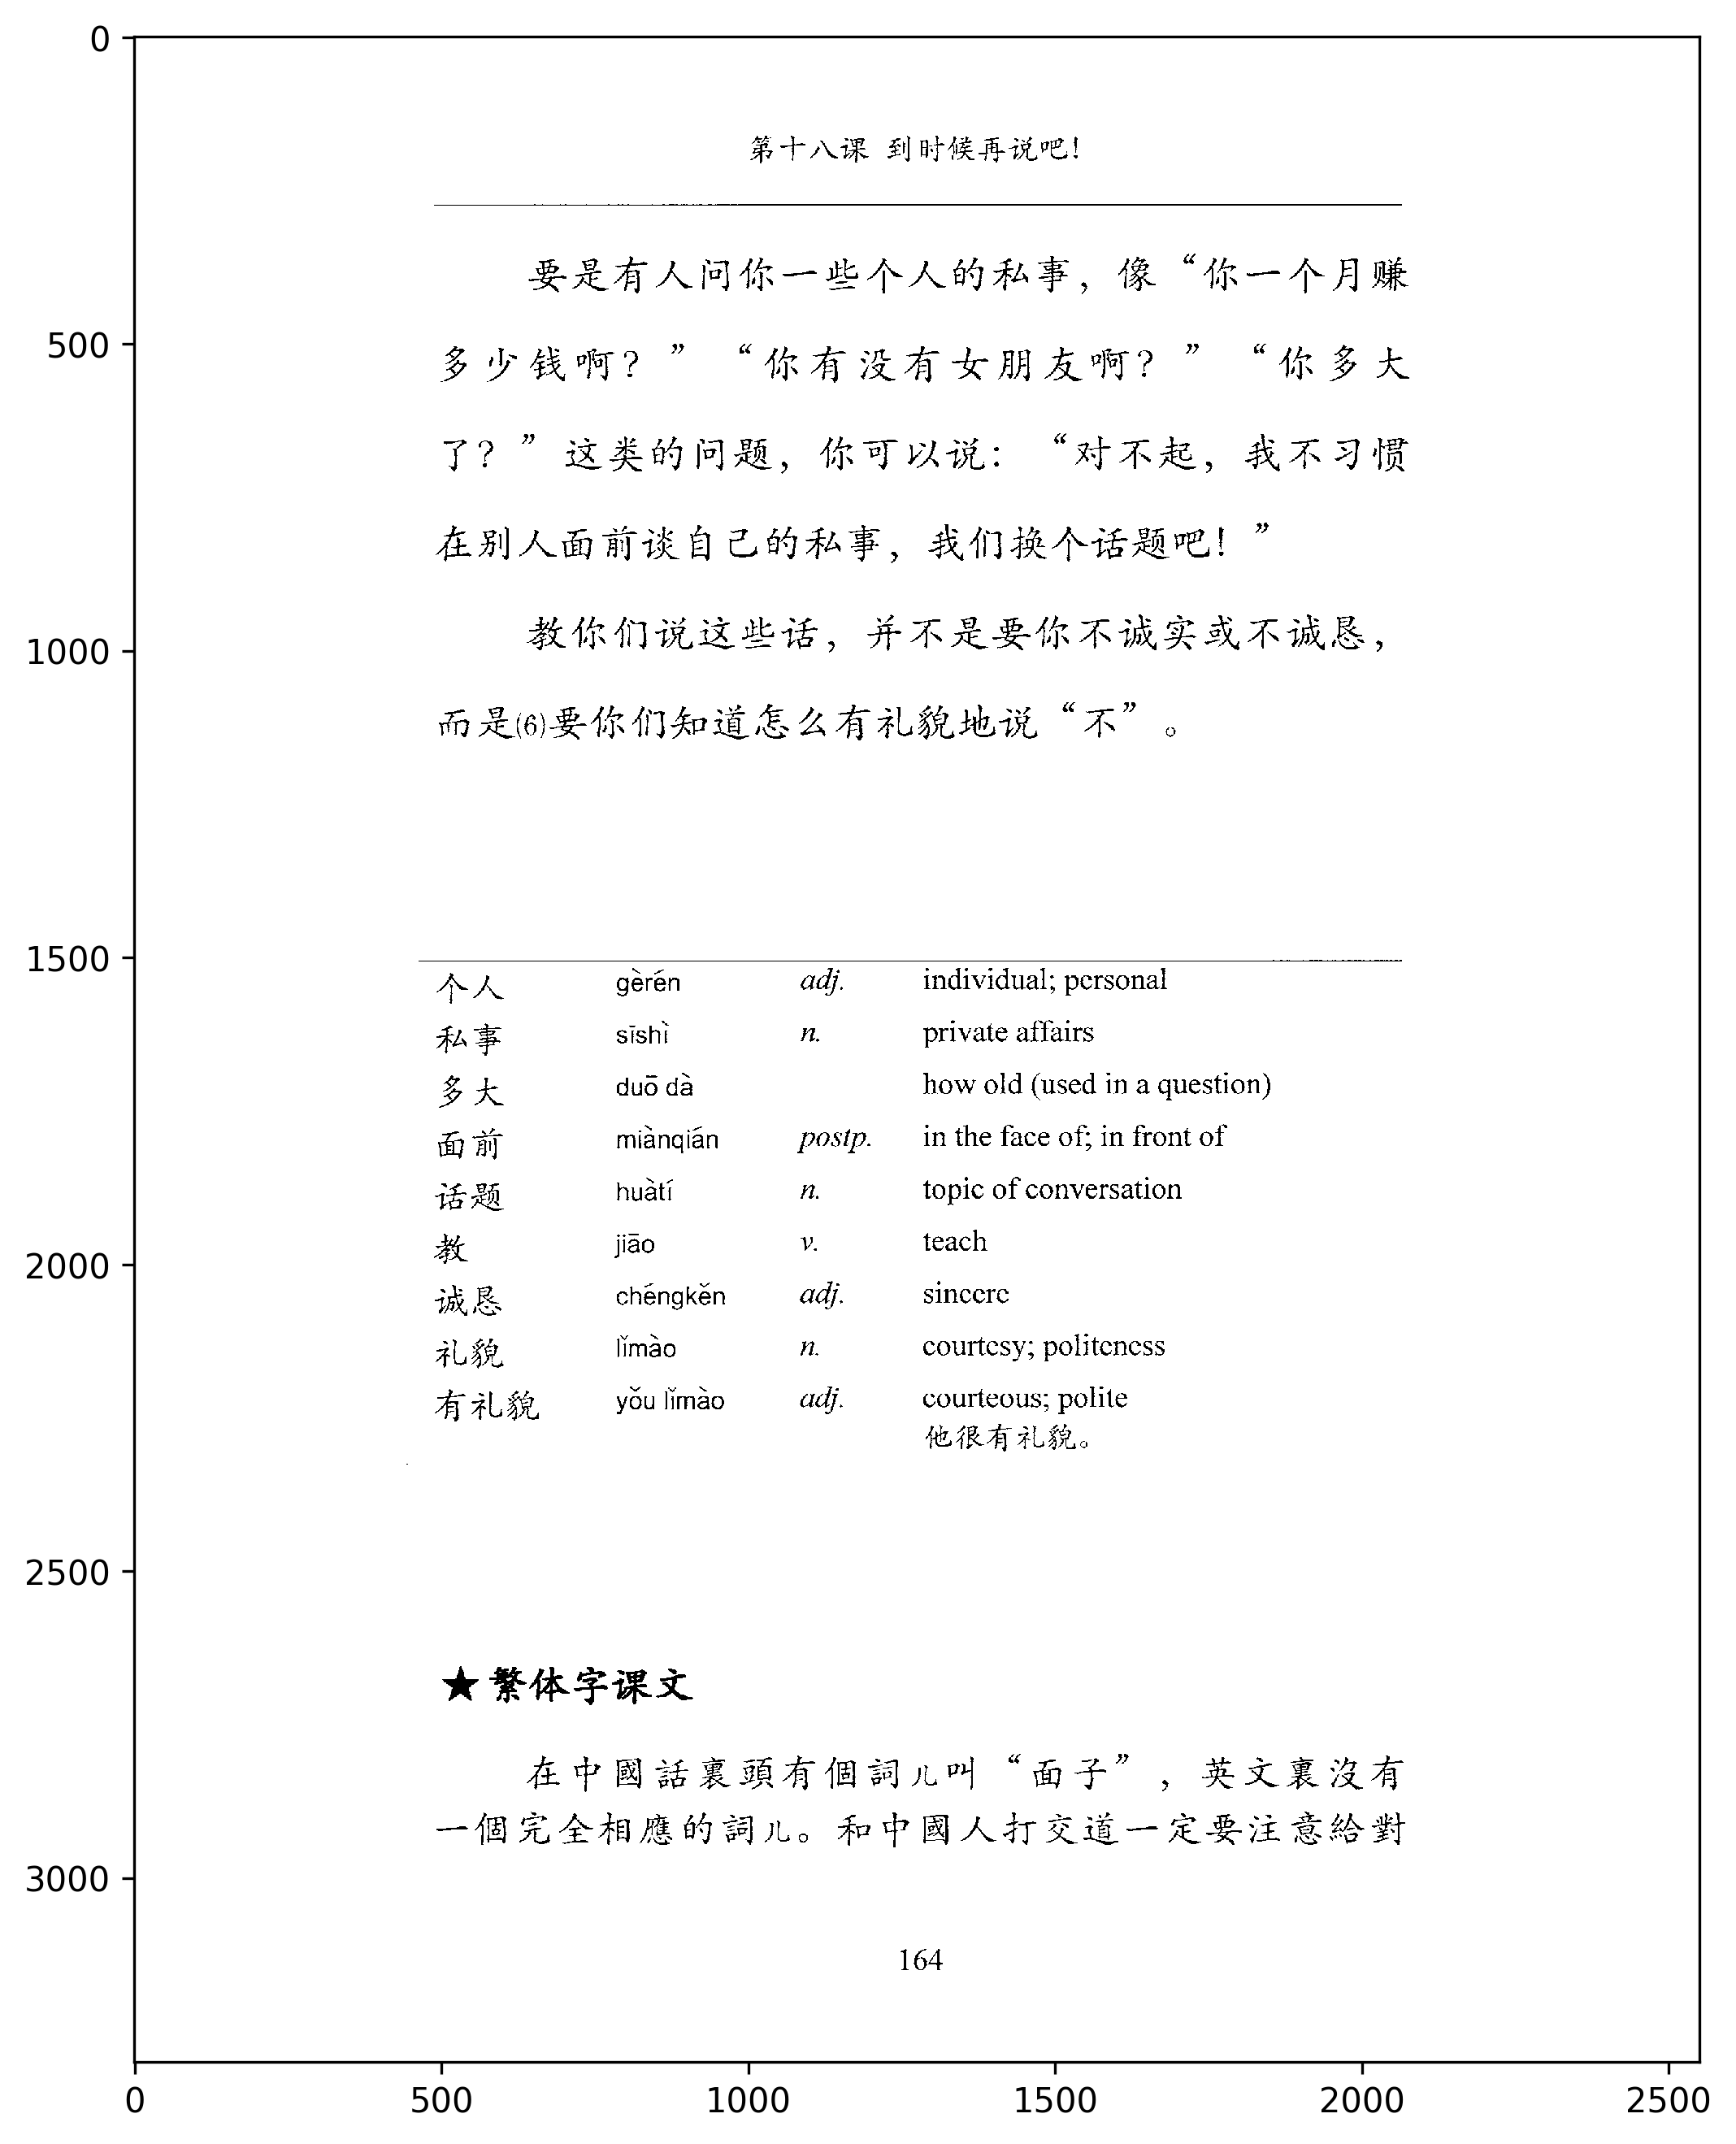

In [6]:
im = cv2.imread('181.jpg')
im_flat = im[:,:,0]
print im.shape
plt.figure(figsize = (8.5,11), dpi=300)
plt.imshow(im)

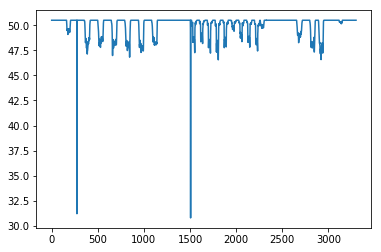

In [7]:
def get_white_score(a):
    b = a**2
    t = np.sum(b)
    t = np.sqrt(t)
    return t

scores = np.apply_along_axis(get_white_score, 1, im_flat)
plt.plot(scores)

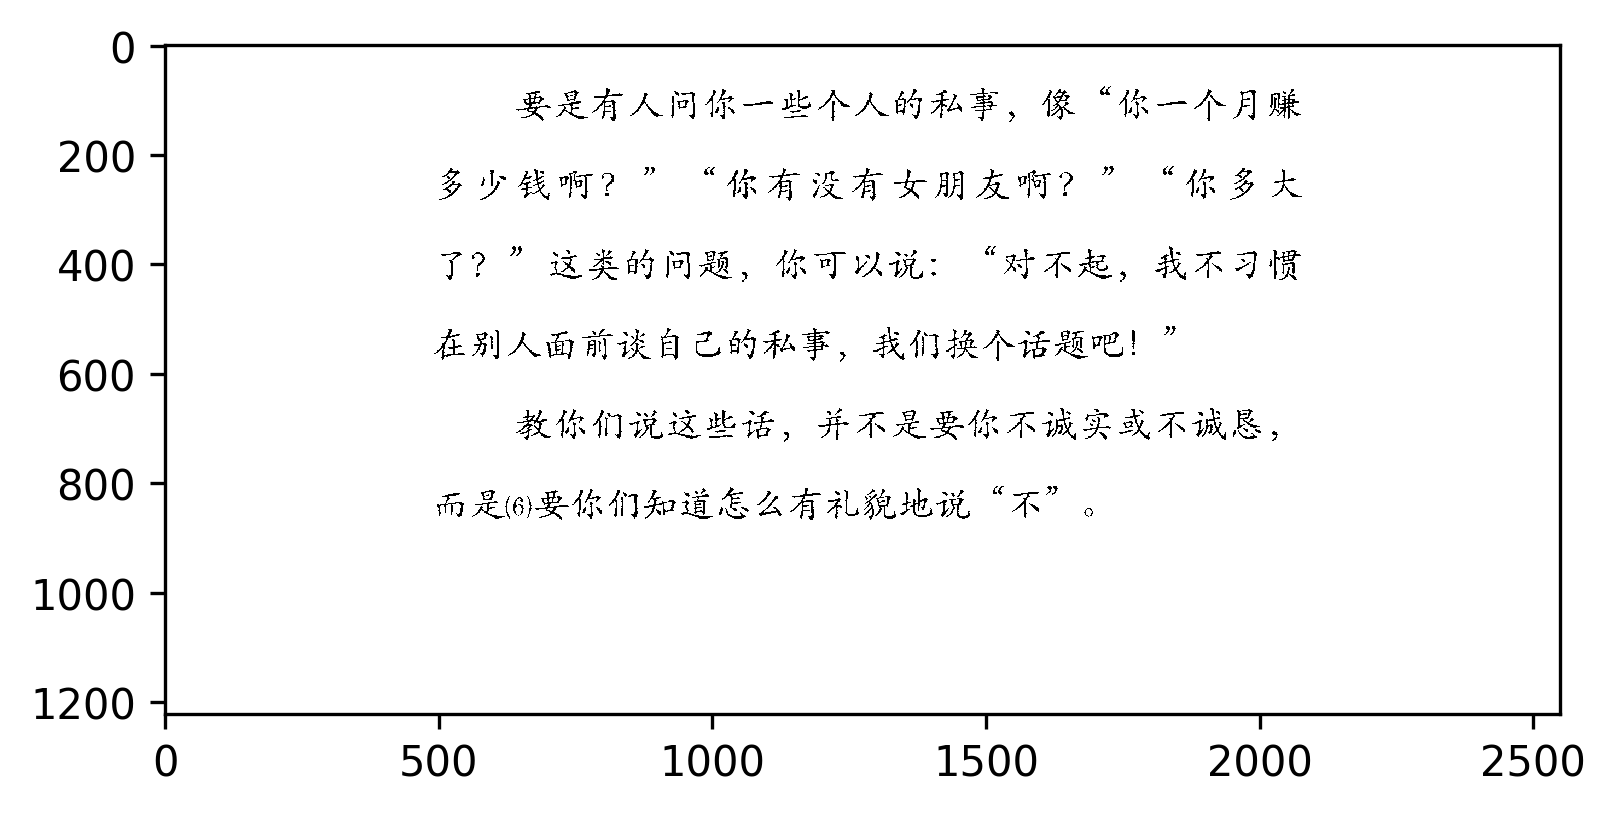

In [8]:
ss = sorted(enumerate(scores), key=lambda i : i[1])
l1 = ss[0][0]
for i in ss:
    if abs(i[0] - l1) > 10:
        l2 = i[0]
        break
    
l1, l2 = min(l1, l2)+5, max(l1, l2)-5
    
im_crop = im[l1:l2]
im_crop_flat = im_flat[l1:l2]
plt.figure(dpi=300)
plt.imshow(im_crop)

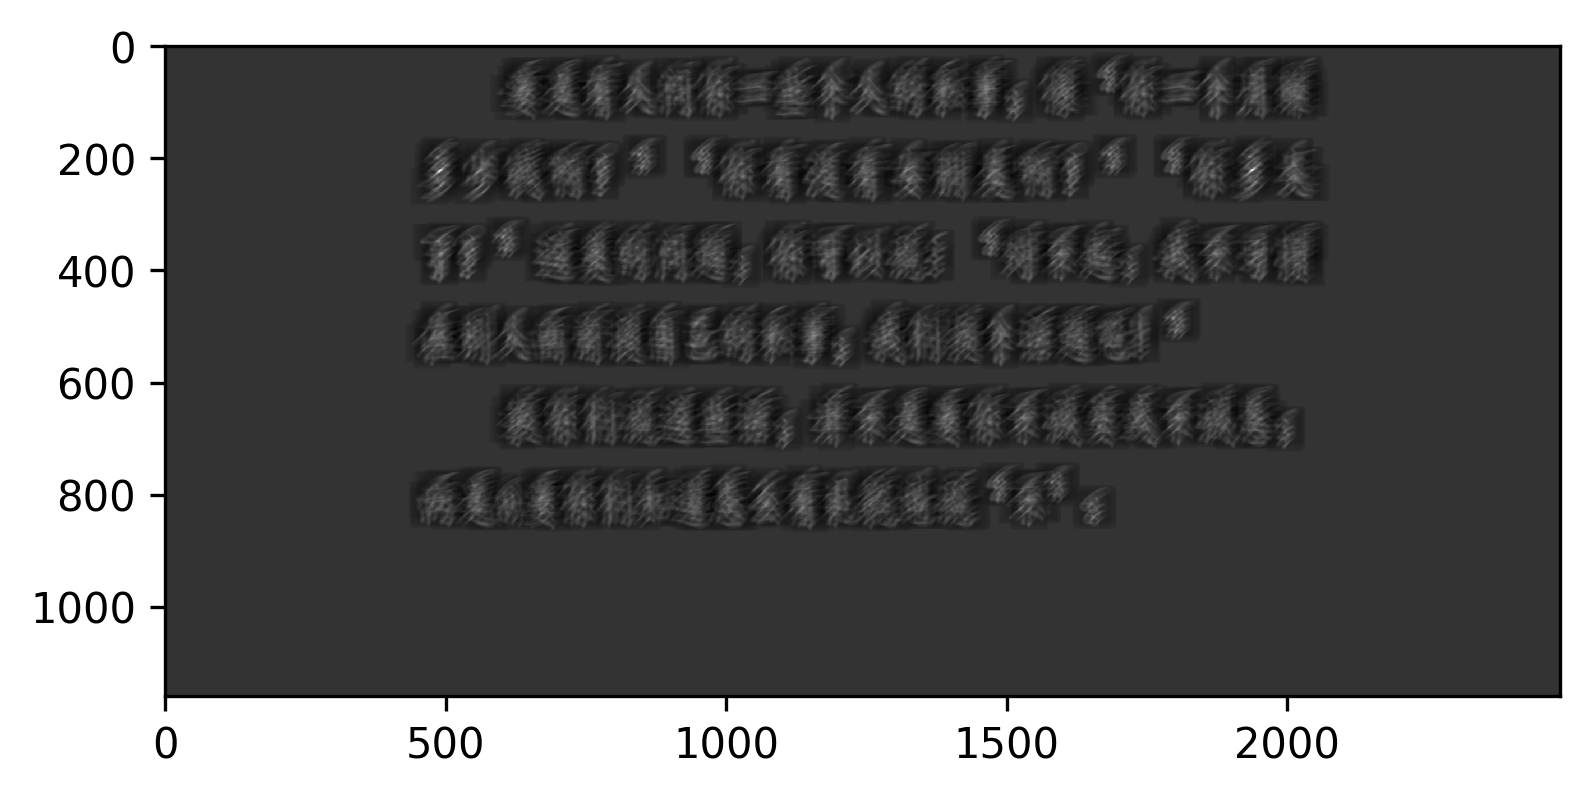

In [9]:
char = get_char_img(u'多')
res = cv2.matchTemplate(im_crop, char, cv2.TM_CCOEFF_NORMED)
plt.figure(dpi=300)
plt.imshow(res, cmap='gray')

(222, 1938)
(223, 490)


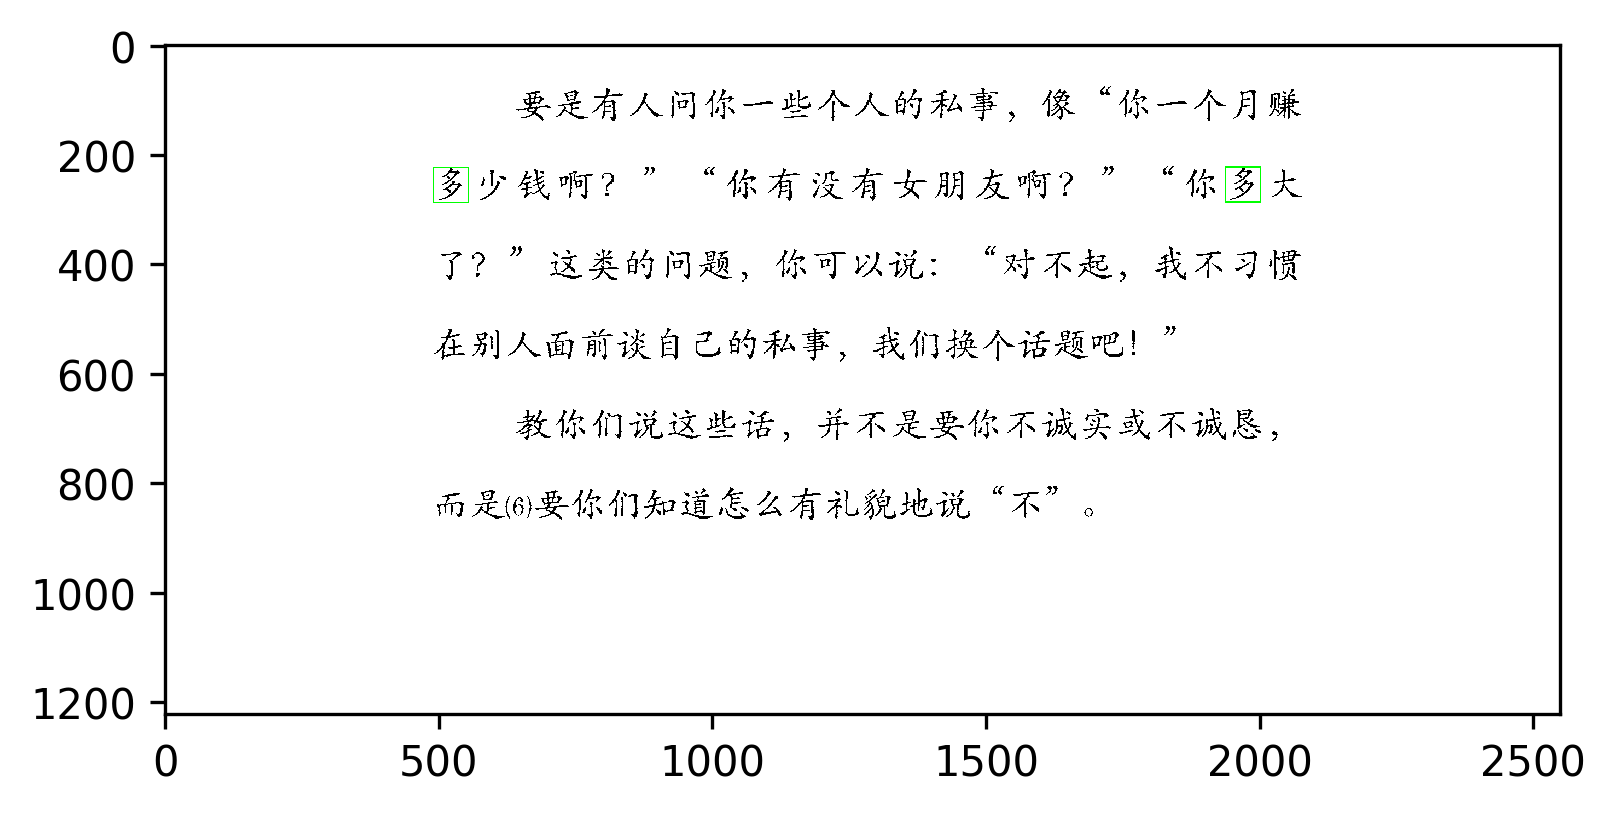

In [10]:
def dist(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

loc = []
sp = np.where(res >= 0.7)
sp = zip(*sp[::1])
sp = sorted(sp, key=lambda p: res[p], reverse=True)

for p in sp:
    ins = True
    for l in loc:
        if dist(p, l) < 32:
            ins = False
    if ins:
        loc.append(p)

im_edit = im_crop.copy()
for pt in loc:
    print pt
    cv2.rectangle(im_edit, (pt[1], pt[0]), (pt[1] + 64, pt[0] + 64), (0,255,0), 2)
plt.figure(dpi=300)
plt.imshow(im_edit)

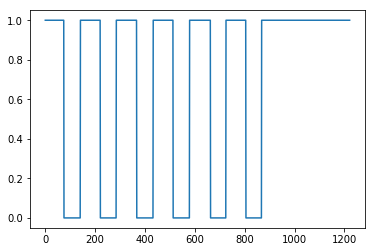

In [11]:
def is_white(a):
    return (a == 255).all()

white_lines = np.apply_along_axis(is_white, 1, im_crop_flat)
plt.plot(white_lines)      

In [12]:
char_lines = []
b = True
st = 0
for l in enumerate(white_lines):
    if b:
        if not l[1]:
            b = l[1]
            st = l[0]
    else:
        if l[1]:
            b = l[1]
            char_lines.append((st, l[0]))
            
print char_lines

[(75, 141), (221, 285), (367, 433), (513, 579), (663, 725), (805, 868)]


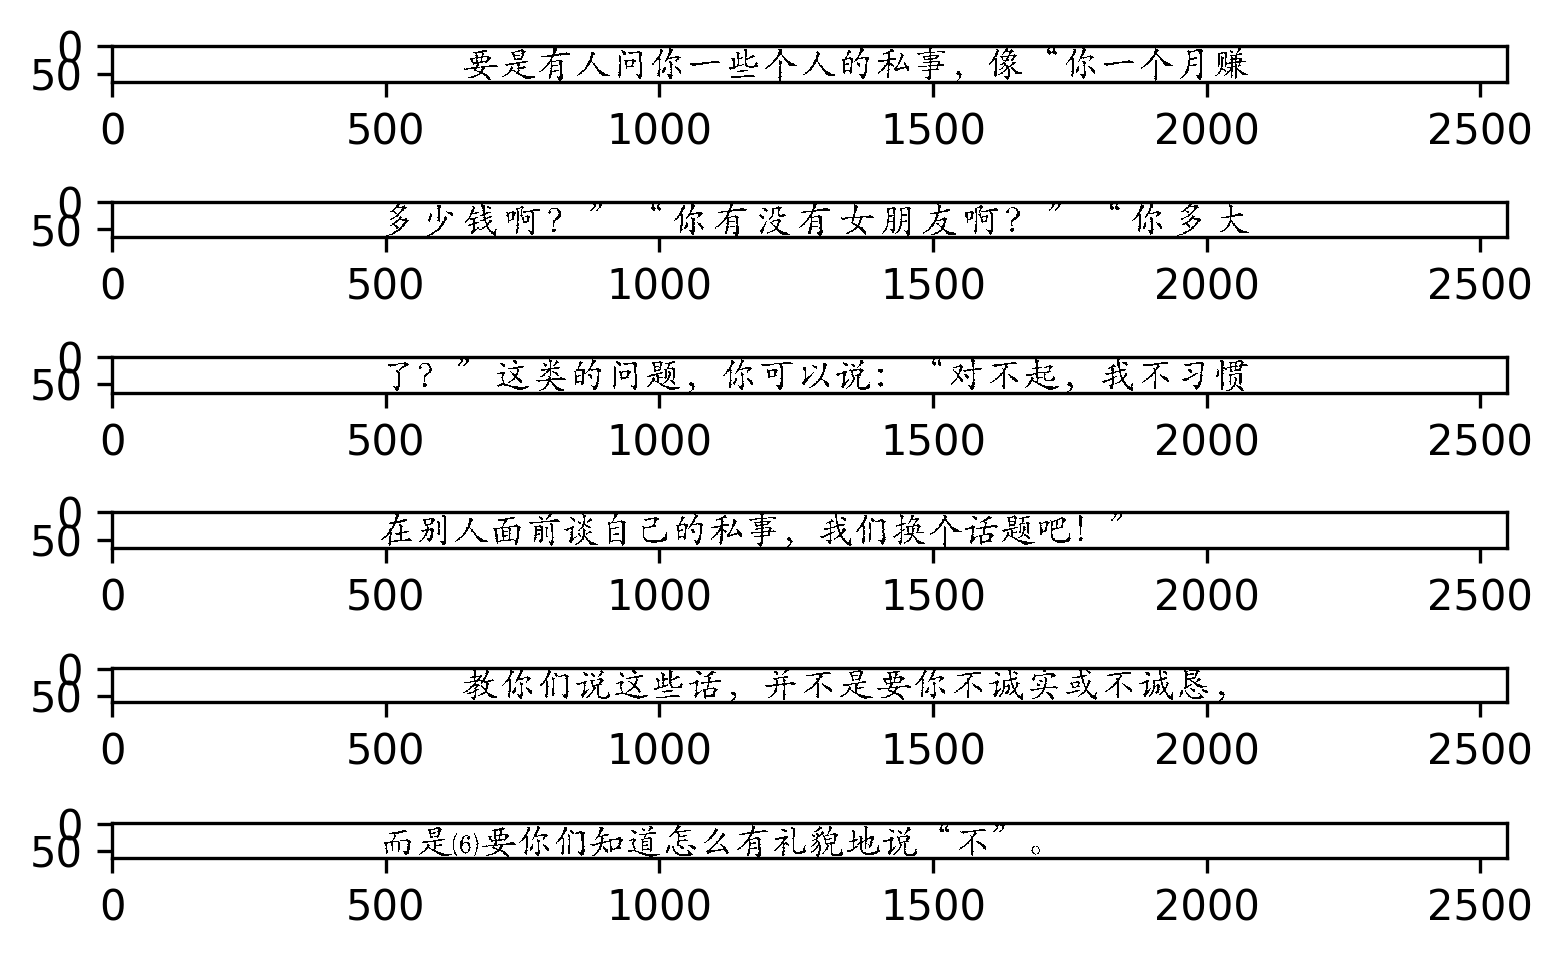

In [13]:
im_line = map(lambda c: im_crop[c[0]:c[1]], char_lines)
im_line_flat = map(lambda c: im_crop_flat[c[0]:c[1]], char_lines)
fig, axes = plt.subplots(len(char_lines), dpi=300)
for i in range(0, len(char_lines)):
    axes[i].imshow(im_line[i])

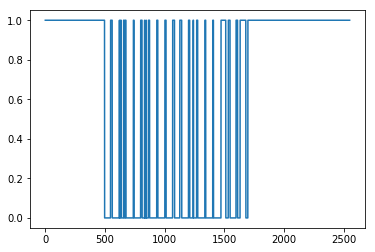

In [14]:
line_scores = np.apply_along_axis(is_white, 0, im_line_flat[5])
plt.plot(line_scores)

In [15]:
def get_line_chars(line):
    line_scores = np.apply_along_axis(is_white, 0, line)

    temp_chars = []
    b = True
    st = 0
    for l in enumerate(line_scores):
        if b:
            if not l[1]:
                b = l[1]
                st = l[0]
        else:
            if l[1]:
                b = l[1]
                temp_chars.append((st, l[0]))
                

    cd = []
    for i in range(0, len(temp_chars) - 1):
        if temp_chars[i+1][0] - temp_chars[i][1] < 5:
            cd.append(True)
        else:
            cd.append(False)

    cd.append(False)

    chars = []

    i = 0
    while i < len(cd):
        if cd[i]:
            j = i
            while j < len(cd):
                if not cd[j]:
                    break
                j+=1
            if j == len(cd):
                chars.append((temp_chars[i][0], temp_chars[-1][1]))
            else:
                chars.append((temp_chars[i][0], temp_chars[j][1]))
            i = j + 1
        else:
            chars.append(temp_chars[i])
            i+=1


    chars = filter(lambda i: i[1] - i[0] > 30, chars)

    return chars

all_chars = []
for l in range(0, len(im_line_flat)):
    all_chars.append(get_line_chars(im_line_flat[l]))

而 ér
0.7721892
要 yào
0.8067943
你 nǐ
0.82642
们 men
0.8337589
知 zhī
0.8047491
道 dào
0.8250149
怎 zěn
0.7511706
么 me
0.84794396
有 yǒu
0.8727993
礼 lǐ
0.7100395
貌 mào
0.6441176
地 de dì
0.7909328
说 shuō
0.7680276
不 bù
0.8620027


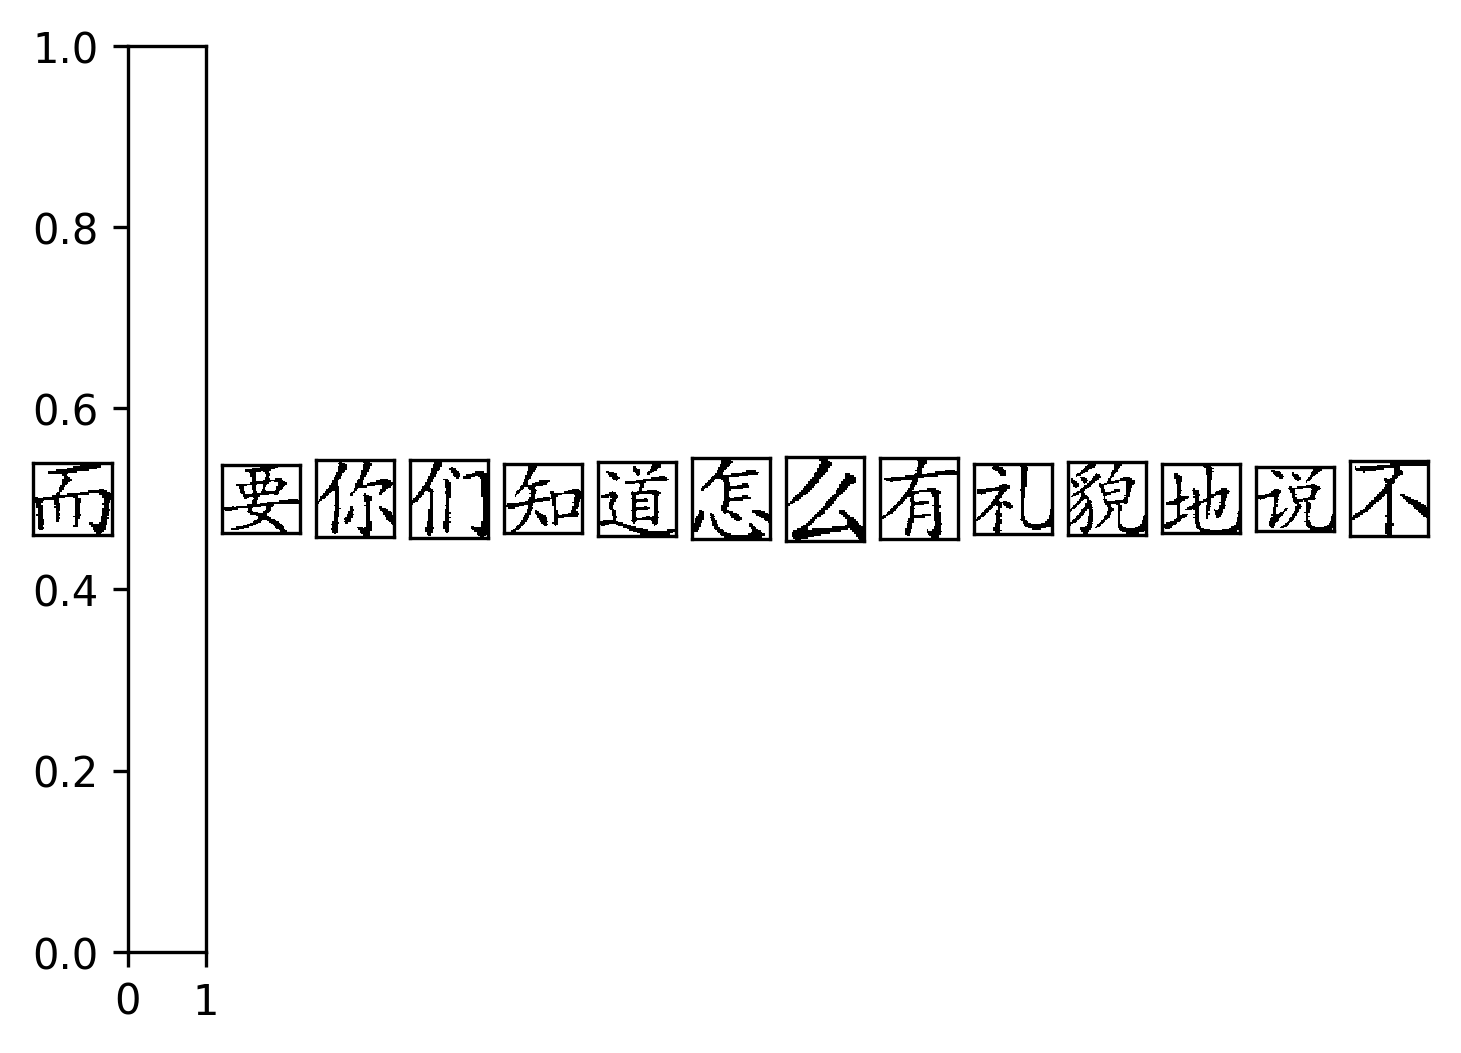

In [16]:
def cut_whitespace(c):
    c_flat = c[:,:,0]
    white_vert = np.apply_along_axis(is_white, 0, c_flat)
    white_horiz = np.apply_along_axis(is_white, 1, c_flat)
    pos_vert = np.argwhere(white_vert == False)
    pos_horiz = np.argwhere(white_horiz == False)
    return c[pos_horiz[0][0]:pos_horiz[-1][0], pos_vert[0][0]:pos_vert[-1][0],:]

def ocr_line(l):
    char_ind = []
    fig, axes = plt.subplots(1, len(all_chars[l]), dpi=300)
    for i in range(0, len(all_chars[l])):
        tc = cut_whitespace(im_line[l][:,all_chars[l][i][0]:all_chars[l][i][1],:])
        if tc.shape[0] > 64 or tc.shape[1] > 64:
            char_ind.append(None)
            continue
        sim = np.apply_along_axis(lambda c: cv2.matchTemplate(c.reshape(64,64,3), tc, cv2.TM_CCOEFF_NORMED).max(), 1, mandarin['imgs'])
        print mandarin['chars'][np.argmax(sim)]['char'], mandarin['chars'][np.argmax(sim)]['pinyin'], np.max(sim)
        char_ind.append(np.argmax(sim))
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].imshow(tc)
    return char_ind
    
    
char_inds = ocr_line(5)

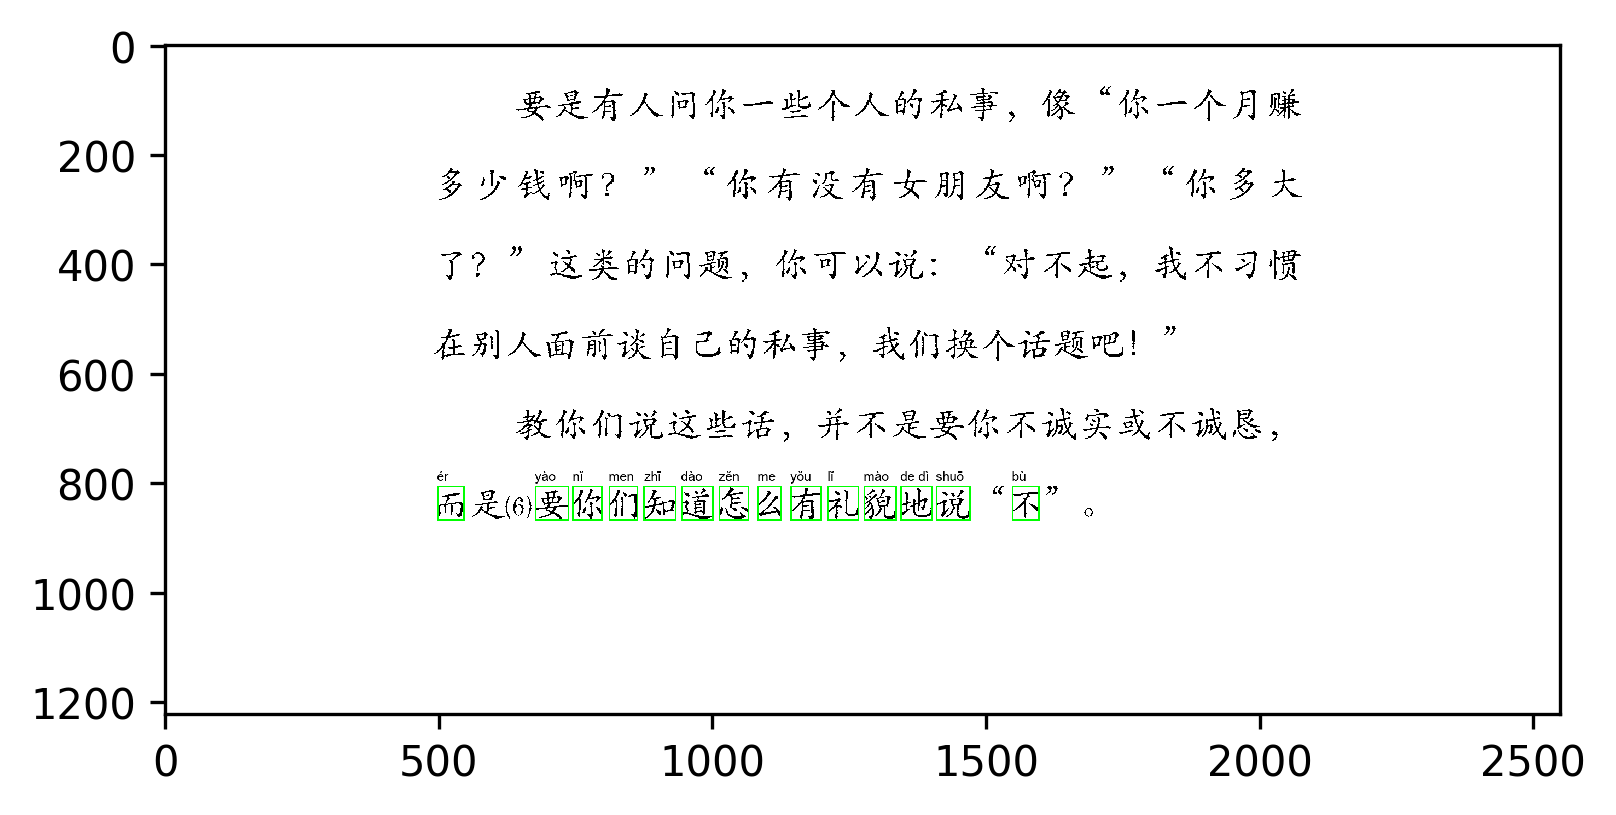

In [17]:
im_char = Image.fromarray(im_crop)
draw = ImageDraw.Draw(im_char)
for i in range(0, len(all_chars[5])):
    if char_inds[i] != None:
        draw.text((all_chars[5][i][0], char_lines[5][0] - 35), mandarin['chars'][char_inds[i]]['pinyin'].decode('utf-8') ,(0,0,0),font=arial)
        draw.rectangle([(all_chars[5][i][0], char_lines[5][0]), (all_chars[5][i][1], char_lines[5][1])], outline=(0,255,0), width=3)
    
del draw
im_char = np.array(im_char)

plt.figure(dpi=300)
plt.imshow(im_char)

要 yào
0.78301036
是 shì
0.8468042
有 yǒu
0.87231505
人 rén
0.9098466
问 wèn
0.79466504
你 nǐ
0.8317743
一 yī
0.9316483
些 xiē
0.83527076
个 gè
0.8316219
人 rén
0.8939242
的 de
0.7937929
私 sī
0.8130516
事 shì
0.72301126
像 xiàng
0.7661627
你 nǐ
0.8244936
一 yī
0.9157046
个 gè
0.8420817
月 yuè
0.7963636
赚 zhuàn
0.77295333
多 duō
0.73828614
少 shǎo
0.88998663
钱 qián
0.7691267
啊 a
0.7022889
你 nǐ
0.8239779
有 yǒu
0.85233545
没 méi
0.8419962
有 yǒu
0.84744984
女 nǚ
0.7502255
朋 péng
0.6257214
友 yǒu
0.85211927
啊 a
0.70966274
你 nǐ
0.8318936
多 duō
0.75885534
大 dà
0.8664919
了 le
0.8984285
这 zhè
0.6937826
类 lèi
0.8100975
的 de
0.81204426
问 wèn
0.8098747
题 tí
0.79108393
你 nǐ
0.82164866
可 kě
0.8422299
以 yǐ
0.83789146
说 shuō
0.761446
对 duì
0.82130057
不 bù
0.85263973
起 qǐ
0.79842424
我 wǒ
0.7637002
不 bù
0.8378901
习 xí
0.71315676
惯 guàn
0.7039712
在 zài
0.8353919
人 rén
0.895398
面 miàn
0.6647257
前 qián
0.688144
谈 tán
0.7229525
自 zì
0.71661377
已 yǐ
0.84237766
的 de
0.81799334
私 sī
0.80754256
事 shì
0.7887605
我 wǒ
0.7412838
们 men
0

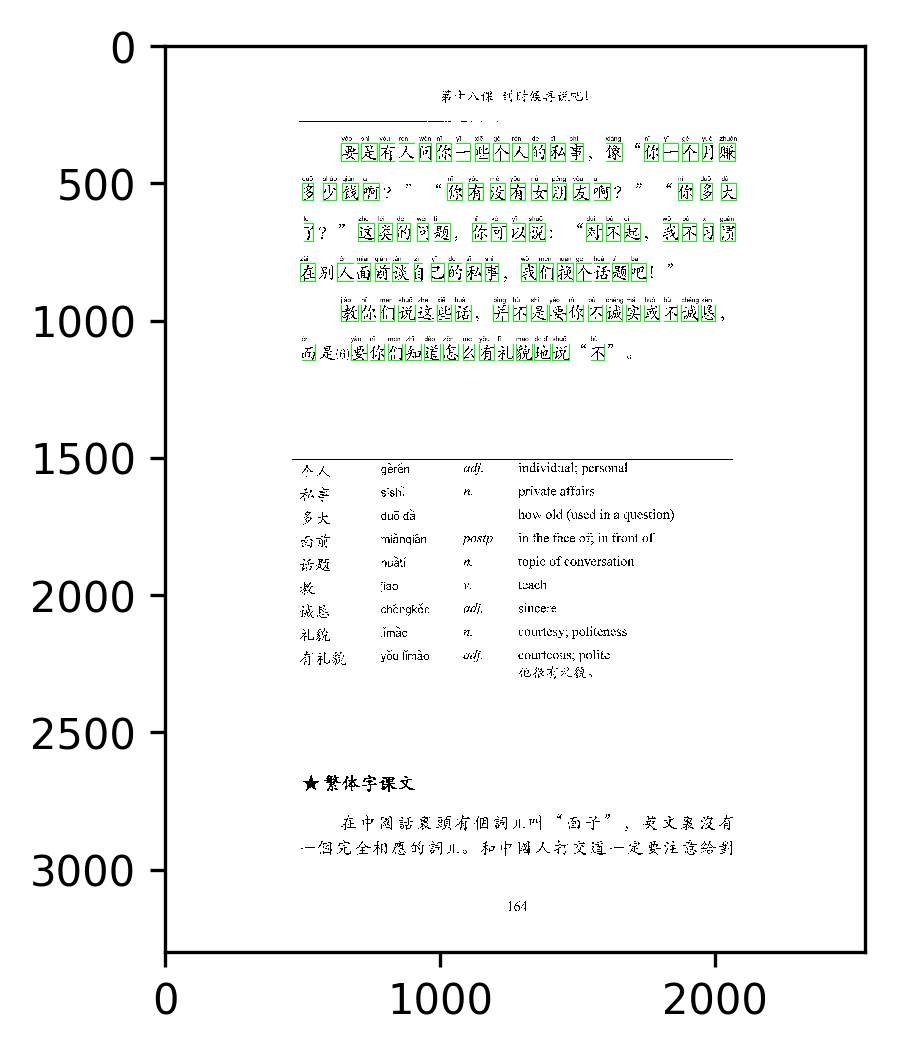

In [20]:
def ocr(n):
    filename = str(n) + '.jpg'
    get_image_page('/Users/billy/Downloads/china.pdf', filename, n, 300)
    im = cv2.imread(filename)
    im_flat = im[:,:,0]
    scores = np.apply_along_axis(get_white_score, 1, im_flat)
    
    ss = sorted(enumerate(scores), key=lambda i : i[1])
    l1 = ss[0][0]
    for i in ss:
        if abs(i[0] - l1) > 10:
            l2 = i[0]
            break

    l1, l2 = min(l1, l2)+5, max(l1, l2)-5

    im_overlay = Image.fromarray(im)
    draw_overlay = ImageDraw.Draw(im_overlay)
    im_crop = im[l1:l2]
    im_crop_flat = im_flat[l1:l2]
    
    white_lines = np.apply_along_axis(is_white, 1, im_crop_flat)
    
    char_lines = []
    b = True
    st = 0
    for l in enumerate(white_lines):
        if b:
            if not l[1]:
                b = l[1]
                st = l[0]
        else:
            if l[1]:
                b = l[1]
                char_lines.append((st, l[0]))

    im_line = map(lambda c: im_crop[c[0]:c[1]], char_lines)
    im_line_flat = map(lambda c: im_crop_flat[c[0]:c[1]], char_lines)
    
    for l in range(0, len(im_line_flat)):
        char_pos = get_line_chars(im_line_flat[l])
        for i in range(0, len(char_pos)):
            tc = cut_whitespace(im_line[l][:,char_pos[i][0]:char_pos[i][1],:])
            if tc.shape[0] > 64 or tc.shape[1] > 64:
                continue
            sim = np.apply_along_axis(lambda c: cv2.matchTemplate(c.reshape(64,64,3), tc, cv2.TM_CCOEFF_NORMED).max(), 1, mandarin['imgs'])
            print mandarin['chars'][np.argmax(sim)]['char'], mandarin['chars'][np.argmax(sim)]['pinyin'], np.max(sim)
            draw_overlay.text((char_pos[i][0], l1 + char_lines[l][0] - 35), mandarin['chars'][np.argmax(sim)]['pinyin'].decode('utf-8') ,(0,0,0),font=arial)
            draw_overlay.rectangle([(char_pos[i][0], l1 + char_lines[l][0]), (char_pos[i][1], l1 + char_lines[l][1])], outline=(0,255,0), width=3)
            
    del draw_overlay
    im_overlay = np.array(im_overlay)
    
    plt.figure(dpi=300)
    plt.imshow(im_overlay)
    

ocr(182)       